In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
current_palette = sns.color_palette()
import graphviz as gv
from tqdm import tqdm
pd.options.display.float_format = '{:.2f}'.format

DIR = 'C:\\Users\\User\\Notebooks_py\\Hackathon 2022\\'

In [2]:
df = pd.read_csv(f'{DIR}\\2. Новые данные\\statistics-07-20.csv', sep=';')
df.tail()

,index_train,length,car_number,destination_esr,adm,danger,gruz,loaded,operation_car,operation_date,...,operation_st_id,operation_train,receiver,rodvag,rod_train,sender,ssp_station_esr,ssp_station_id,tare_weight,weight_brutto
4189910,860009873840005.00,1.00,62827548,76404.00,NaN,NaN,161185.00,1.00,4.00,2020-07-16 03:29:00,...,2001933484.00,5.00,39513543.00,60.00,10.00,76900054.00,860009.00,2001933484.00,NaN,6256.00
4189911,860009873840005.00,1.00,62827548,76404.00,NaN,NaN,161185.00,1.00,4.00,2020-07-16 03:30:00,...,2001933484.00,5.00,39513543.00,60.00,10.00,76900054.00,860009.00,2001933484.00,NaN,6256.00
4189912,830200941862201.00,NaN,62827910,862201.00,NaN,NaN,NaN,2.00,3.00,2020-07-15 20:00:00,...,2001930776.00,4.00,NaN,60.00,10.00,NaN,862201.00,2001930776.00,NaN,1756.00
4189913,NaN,NaN,62827514,968302.00,NaN,NaN,NaN,1.00,80.00,2020-07-16 02:37:00,...,2000038612.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4189914,NaN,1.00,62827514,968302.00,20.00,NaN,161128.00,NaN,21.00,2020-07-16 04:28:00,...,2000038612.00,NaN,98098048.00,60.00,NaN,0.00,NaN,NaN,249.00,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4189915 entries, 0 to 4189914
Data columns (total 21 columns):
 #   Column            Dtype  
---  ------            -----  
 0   index_train       float64
 1   length            float64
 2   car_number        int64  
 3   destination_esr   float64
 4   adm               float64
 5   danger            float64
 6   gruz              float64
 7   loaded            float64
 8   operation_car     float64
 9   operation_date    object 
 10  operation_st_esr  float64
 11  operation_st_id   float64
 12  operation_train   float64
 13  receiver          float64
 14  rodvag            float64
 15  rod_train         float64
 16  sender            float64
 17  ssp_station_esr   float64
 18  ssp_station_id    float64
 19  tare_weight       float64
 20  weight_brutto     float64
dtypes: float64(19), int64(1), object(1)
memory usage: 671.3+ MB


index_train - Индекс поезда  
length - Длина вагона  
car_number - Номер вагона  
destination_esr - ЕСР станции назначения вагона   
adm - Код АСОУП администрации-собственника вагона  
danger - Признак опасного груза в вагоне. 1 - в вагоне опасный груз,  null - иначе  
gruz - Код груза  
loaded - Признак груженого вагона. 1 -  груженый, 2- порожний  
operation_car - Код операции ВМ АСОУП  
operation_date - Дата операции  
operation_st_esr - ЕСР станции операции  
operation_st_id - ID станции операции  
operation_train - Код операции ПМ АСОУП  
receiver - ОКПО грузополучателя  
rodvag - Род вагона АСОУП (учетного)  
rod_train - Род поезда АСОУП  
sender - ОКПО грузоотправителя  
ssp_station_esr - ЕСР станция ССП  
ssp_station_id - id станции ССП  
tare_weight - Вес тары вагона (ц)  
weight_brutto - weight_brutto  

In [44]:
# Дополнительные данные
# Расшифровка операций с поездами
train_oper_dict = pd.read_csv(f'{DIR}RZD-hackathon\\VIVSD_ASOUP_NSI_TN_OPER_POEZD.csv')
# Расшифровка операций с вагонами
car_oper_dict = pd.read_csv(f'{DIR}RZD-hackathon\\VIVSD_ASOUP_NSI_TN_OPER_VAG.csv')


def get_train_oper(operation_train):
    try:
        result = train_oper_dict[train_oper_dict.kop==operation_train].mnem_oper.values[0]
    except:
        result = 'UNKNOWN'
    return result

def get_car_oper(operation_car, short=False):
    if short: column_name = 'mnem_oper'
    else: column_name = 'naimen_oper'    
    try:
        result = car_oper_dict[car_oper_dict.kop==operation_car][column_name].values[0]
    except:
        result = 'UNKNOWN'
    return result

In [45]:
def operations_chain(car_number, operation_st_esr):
    '''
    Функция формирует таблицу с цепочкой операций для вагона car_number на станции operation_st_esr
    '''
    # список операций с этим вагоном на этой станции, упорядоченный по времени
    df_tmp = df[(df.car_number == car_number)&(df.operation_st_esr==operation_st_esr)].sort_values(by='operation_date')
    
    operations_chain = pd.DataFrame()
    
    operations_chain['start_oper_date'] = df_tmp['operation_date'].iloc[:-1].values
    operations_chain['start_oper'] = df_tmp['operation_car'].fillna(-1).iloc[:-1].values
    operations_chain['end_oper_date'] = df_tmp['operation_date'].iloc[1:].values
    operations_chain['end_oper'] = df_tmp['operation_car'].fillna(-1).iloc[1:].values
    operations_chain['duration'] = (operations_chain['end_oper_date'] - operations_chain['start_oper_date'])
    # приведем продолжительность операции к формату часы
    operations_chain['duration'] = (operations_chain['duration']/np.timedelta64(1, 'h')).astype(float)
    return operations_chain

In [46]:
def get_graf(car_st, to_pdf=False):
    '''
    Функция строит граф из цепочек операций с вагоном car_number на станции operation_st_esr
    '''
    
    car_number = int(str(car_st)[:8])
    operation_st_esr = int(str(car_st)[8:])
    
    chain = operations_chain(car_number, operation_st_esr)
    
    g = gv.Digraph(filename=f'graph_{car_number}-{operation_st_esr}')
    g.attr(rankdir='LR', size='9')
       
    for i in range(len(chain)):
        start_oper_num = chain['start_oper'].iloc[i].astype(int)
        start_oper_name = get_car_oper(chain['start_oper'].iloc[i], short=True)
        src = start_oper_num.astype(str)+', '+get_car_oper(chain['start_oper'].iloc[i], short=True)
        
        end_oper_num = chain['end_oper'].iloc[i].astype(int)
        end_oper_name = get_car_oper(chain['end_oper'].iloc[i], short=True)
        trg = end_oper_num.astype(str)+', '+get_car_oper(chain['end_oper'].iloc[i], short=True)
        
        wgt = round(chain['duration'].iloc[i],2).astype(str)
        
        g.edge(src, trg, label=wgt)
        
    display(chain)
    print(f'Вагон №: {car_number}, станция №: {operation_st_esr}\n')
    
    # добавим описание оперций
    print('Расшифровка операций:')
    nodes = list(chain['start_oper'])
    nodes.append(chain['end_oper'].iloc[-1:].values[0])
    for i in list(set(nodes)): print(i,get_car_oper(i))

    if to_pdf: result = g.view()
    else: result = g
    return result

In [4]:
# Приведем дату и время в формат timestamp
df['operation_date'] = pd.to_datetime(df.operation_date)

In [5]:
# на всякий случай сохраним данные с nan
df_nan = df[df.operation_st_esr.isnull()].copy()
# для дальнейшей работы уберем неизвестные станции
df = df[df.operation_st_esr.notnull()]
df['car_st'] = df['car_number']*1000000+df['operation_st_esr'].astype(int)
#df['car_st'] = df['car_number'].astype(str)+'-'+df['operation_st_esr'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4189317 entries, 0 to 4189914
Data columns (total 22 columns):
 #   Column            Dtype         
---  ------            -----         
 0   index_train       float64       
 1   length            float64       
 2   car_number        int64         
 3   destination_esr   float64       
 4   adm               float64       
 5   danger            float64       
 6   gruz              float64       
 7   loaded            float64       
 8   operation_car     float64       
 9   operation_date    datetime64[ns]
 10  operation_st_esr  float64       
 11  operation_st_id   float64       
 12  operation_train   float64       
 13  receiver          float64       
 14  rodvag            float64       
 15  rod_train         float64       
 16  sender            float64       
 17  ssp_station_esr   float64       
 18  ssp_station_id    float64       
 19  tare_weight       float64       
 20  weight_brutto     float64       
 21  car_st  

In [6]:
#удалим данные, в которых один вагон на одной станции встречается один раз, т.е. нет цепочек операций
no_chains_car_st = df.car_st.value_counts().reset_index()
no_chains_car_st = no_chains_car_st[no_chains_car_st.car_st > 1]
df = df[df.car_st.isin(no_chains_car_st['index'].values)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3992806 entries, 0 to 4189914
Data columns (total 22 columns):
 #   Column            Dtype         
---  ------            -----         
 0   index_train       float64       
 1   length            float64       
 2   car_number        int64         
 3   destination_esr   float64       
 4   adm               float64       
 5   danger            float64       
 6   gruz              float64       
 7   loaded            float64       
 8   operation_car     float64       
 9   operation_date    datetime64[ns]
 10  operation_st_esr  float64       
 11  operation_st_id   float64       
 12  operation_train   float64       
 13  receiver          float64       
 14  rodvag            float64       
 15  rod_train         float64       
 16  sender            float64       
 17  ssp_station_esr   float64       
 18  ssp_station_id    float64       
 19  tare_weight       float64       
 20  weight_brutto     float64       
 21  car_st  

In [21]:
def get_chains(df):
    '''
    Функция вычисляет цепочки операций и продолжительность их выполнения
    chain - цепочка операций
    duration - продолжительность между текущей и предшествующей операциями
    tot_duration - продолжительность всей цепочки
    full_chain - булевая метка о том, что цепочка не промежуточная, а законченная
    loops - количество повторов одной опреации подряд
    предполагается, что датафрейм заранее отсортирован по id и датам
    '''   
    chains=[]
    duration=[]
    tot_duration=[]
    full_chain=[]
    loops=[]
        
    # first node
    curr_op, next_op = df.operation_car.iloc[0:2].values
    curr_id, next_id = df.car_st.iloc[0:2].values
    chain = str(int(curr_op))
    chains.append(chain)
    dur = 0
    duration.append(dur)
    tot_dur = 0
    tot_duration.append(tot_dur)

    
    if next_id != curr_id or curr_op == -1:
        full_ch = True
    else:
        full_ch = False
    full_chain.append(full_ch)
    
    loop = 0
    loops.append(loop)
    
    # rest nodes
    for i in tqdm(range(1, df.shape[0])):
        prev_op, curr_op = df.operation_car.iloc[i-1:i+1].values
        prev_id, curr_id = df.car_st.iloc[i-1:i+1].values

        if prev_id != curr_id or prev_op == -1:
            chain = str(int(curr_op))
            dur = 0
            tot_dur = 0
            full_ch = True
            loop = 0
        else:
            chain += '_'+(str(int(curr_op)))
            dur = df['operation_date'].iloc[i] - df['operation_date'].iloc[i-1]
            dur = dur/np.timedelta64(1, 'h')
            tot_dur += dur
            full_ch = False
            if curr_op == prev_op:
                loop +=1

        chains.append(chain)
        duration.append(dur)
        tot_duration.append(tot_dur)
        full_chain.append(full_ch)
        loops.append(loop)
    
    full_chain.append(True)
    full_chain = full_chain[1:]
    
    return chains, duration, tot_duration, full_chain, loops

In [22]:
# отсортируем данные по станции, вагону и времени операции. Пропущенные значения заменим на -1
df = df.fillna(-1).sort_values(by=['operation_st_esr','car_number','operation_date'])
df['chains'], df['duration'], df['tot_duration'], df['full_chain'], df['loops'] = get_chains(df)
df

100%|██████████████████████████████████████████████████████████████████████| 3992805/3992805 [08:27<00:00, 7871.84it/s]


,index_train,length,car_number,destination_esr,adm,danger,gruz,loaded,operation_car,operation_date,...,ssp_station_id,tare_weight,weight_brutto,car_st,chains,duration,tot_duration,full_chain,rating,loops
547697,780001251830003.00,-1.00,24286957,830003.00,-1.00,-1.00,-1.00,1.00,3.00,2020-07-19 14:49:00,...,2001930516.00,-1.00,6276.00,24286957830003,3,0.00,0.00,False,small,0
547703,-1.00,-1.00,24286957,830003.00,-1.00,-1.00,-1.00,1.00,80.00,2020-07-19 15:00:00,...,-1.00,-1.00,-1.00,24286957830003,3_80,0.18,0.18,False,small,0
788493,-1.00,1.06,24286957,830003.00,20.00,-1.00,682237.00,-1.00,28.00,2020-07-20 09:00:00,...,-1.00,237.00,-1.00,24286957830003,3_80_28,18.00,18.18,False,small,0
788492,-1.00,1.06,24286957,860009.00,20.00,-1.00,421034.00,-1.00,19.00,2020-07-20 14:38:00,...,-1.00,237.00,-1.00,24286957830003,3_80_28_19,5.63,23.82,False,small,0
788491,-1.00,-1.00,24286957,860009.00,-1.00,-1.00,-1.00,2.00,81.00,2020-07-20 15:12:00,...,-1.00,-1.00,-1.00,24286957830003,3_80_28_19_81,0.57,24.38,True,small,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180048,-1.00,-1.00,68169127,998100.00,-1.00,-1.00,-1.00,2.00,78.00,2020-07-22 09:00:00,...,-1.00,-1.00,-1.00,68169127998100,3_78,0.67,0.67,False,smallest,0
1447159,-1.00,1.00,68169127,993304.00,20.00,-1.00,242016.00,-1.00,10.00,2020-07-25 06:54:00,...,-1.00,215.00,-1.00,68169127998100,3_78_10,69.90,70.57,False,smallest,0
1447172,-1.00,-1.00,68169127,993304.00,-1.00,-1.00,-1.00,1.00,79.00,2020-07-25 07:10:00,...,-1.00,-1.00,-1.00,68169127998100,3_78_10_79,0.27,70.83,False,smallest,0
1447157,998100021997502.00,1.00,68169127,993304.00,-1.00,-1.00,242016.00,1.00,4.00,2020-07-25 12:40:00,...,2000039270.00,-1.00,275.00,68169127998100,3_78_10_79_4,5.50,76.33,False,smallest,0


In [23]:
#df.to_csv('statistics-07-20_chains.csv')

985906.00    204319
967600.00    145535
946801.00    111605
863007.00     93827
864207.00     82605
              ...  
975804.00         2
995600.00         2
917320.00         2
996800.00         2
992602.00         2
Name: operation_st_esr, Length: 711, dtype: int64

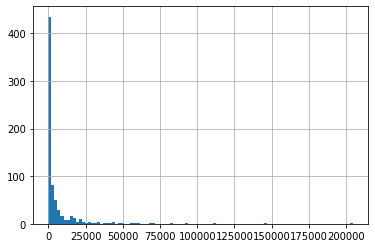

In [24]:
# Добавим признак величины станции по частоте встречаемости
df.operation_st_esr.value_counts(ascending=False).hist(bins=100)
df.operation_st_esr.value_counts(ascending=False)

In [25]:
# на основании графика расставим рейтинг станции
station_rating = pd.DataFrame(df.operation_st_esr.value_counts(ascending=False))
station_rating['rating'] = station_rating['operation_st_esr'].apply(lambda x: 'smallest' if x < 1000 else\
                                                                  ('small' if 1000 <= x < 10000 else\
                                                                  ('medium' if 10000 <= x < 30000 else\
                                                                  ('large' if 30000 <= x < 75000 else\
                                                                  ('largest' ))))
                                                       )
                                                        
station_rating

,operation_st_esr,rating
985906.00,204319,largest
967600.00,145535,largest
946801.00,111605,largest
863007.00,93827,largest
864207.00,82605,largest
...,...,...
975804.00,2,smallest
995600.00,2,smallest
917320.00,2,smallest
996800.00,2,smallest


In [26]:
# Самые популярные цепочки вида 3_..._-1
popular_chains = df.chains\
                    .where(df.full_chain==True)\
                    .where(df.chains.str.startswith('3_'))\
                    .where(df.chains.str.endswith('-1'))\
                    .value_counts(ascending=False)[:20]
popular_chains

3_80_10_4_-1            48583
3_80_11_81_4_-1         33643
3_80_21_18_4_-1         30836
3_80_21_19_81_4_-1      23752
3_18_4_-1               15651
3_80_10_4_4_-1           6319
3_80_18_4_-1             6019
3_80_21_10_4_-1          5851
3_80_80_10_4_-1          4495
3_80_80_11_81_4_-1       4250
3_80_21_18_4_4_-1        4129
3_80_19_81_4_-1          4123
3_80_21_11_81_4_-1       3005
3_28_18_4_-1             2928
3_80_20_10_81_4_-1       2873
3_78_20_10_79_4_-1       2755
3_80_11_81_4_4_-1        2691
3_80_4_-1                2689
3_80_21_19_81_4_4_-1     2594
3_80_11_81_81_4_-1       2119
Name: chains, dtype: int64

In [27]:
def plot_distr(chain, hue=None):
    '''
    Функция строит график распределения продолжительности цепочки операций
    '''
    data = df[['tot_duration','rodvag','rating']][df.chains==chain]
    
    sns.displot(data, x='tot_duration',
                hue=hue,
                kind='hist',
                kde=True,
                height=6, aspect=2,
                palette='tab10'
                )
    plt.xlabel('Продолжительность цепочки операций (час)', fontsize=16)
    plt.ylabel("Количество", fontsize=16)
    plt.xticks(fontsize=12)
    plt.title(f"Распределение продолжительности цепочки операций {chain}", fontsize=18)
    plt.show()
    return

In [28]:
# рассмотрели на конкретном примере сооветствие результатов анализа с
# Probability algorithm Max Andriichuk.ipynb
df.chains.where(df.chains.str.startswith('80_'))\
         .where(df.chains.str.endswith('4'))\
         .value_counts(ascending=False)[:20]

80_10_4          51463
80_11_81_4       10870
80_10_4_4         7019
80_21_81_4        4202
80_4              3089
80_11_81_81_4     2615
80_18_4           2540
80_21_18_4        2108
80_80_10_4        1875
80_10_81_4        1799
80_21_19_81_4     1324
80_10_4_4_4       1020
80_80_11_81_4      954
80_19_81_4         949
80_81_4            860
80_11_81_4_4       753
80_4_4             649
80_21_18_4_4       486
80_28_18_4         414
80_80_18_4         368
Name: chains, dtype: int64

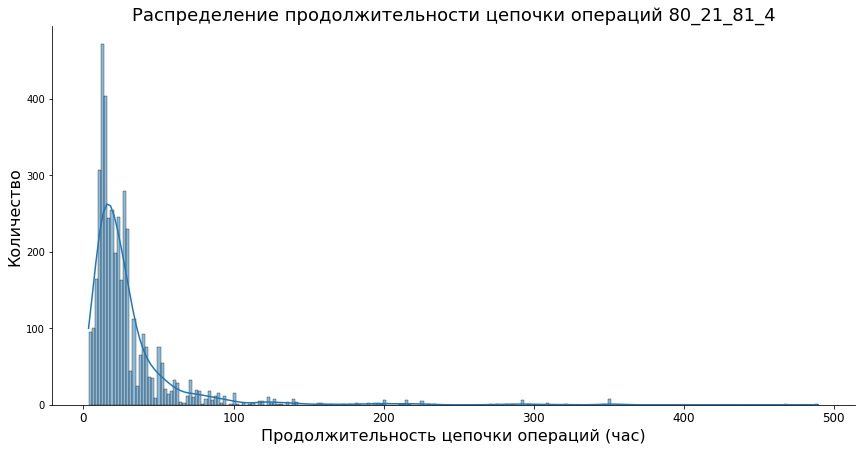

In [29]:
plot_distr('80_21_81_4')

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


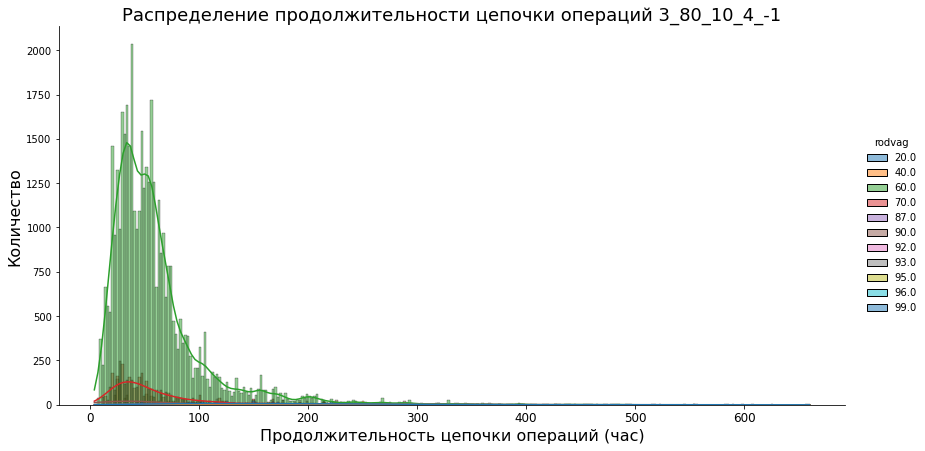

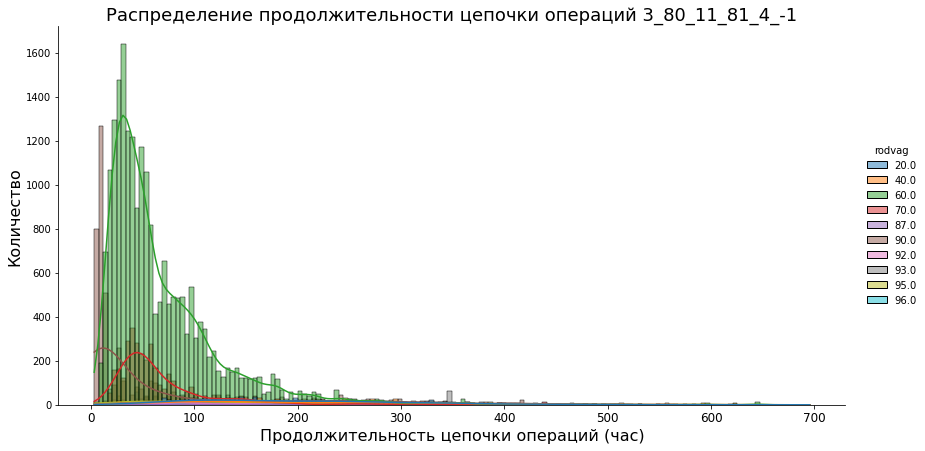

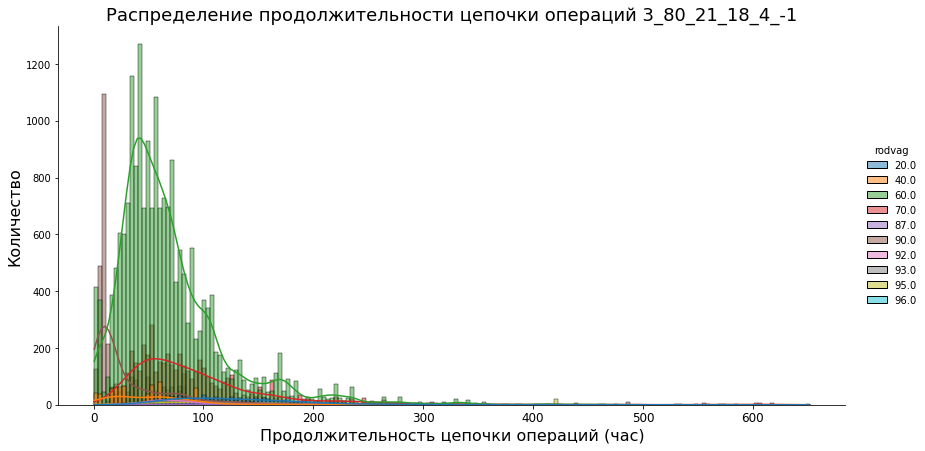

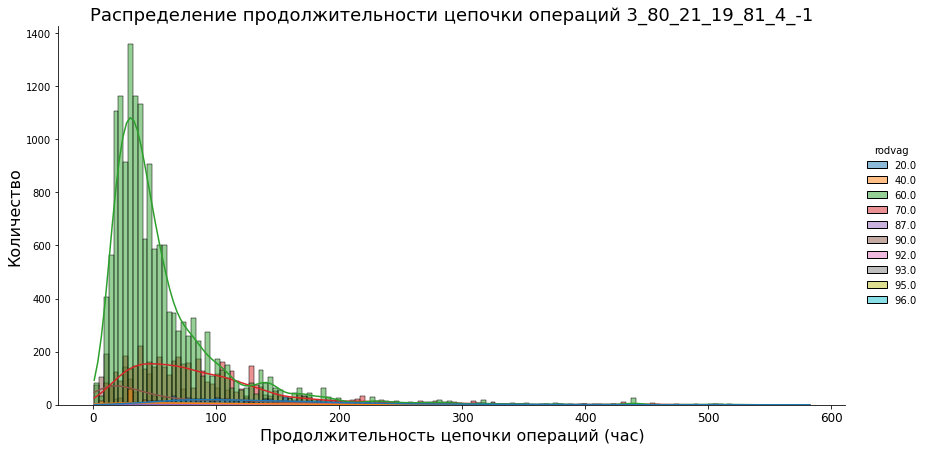

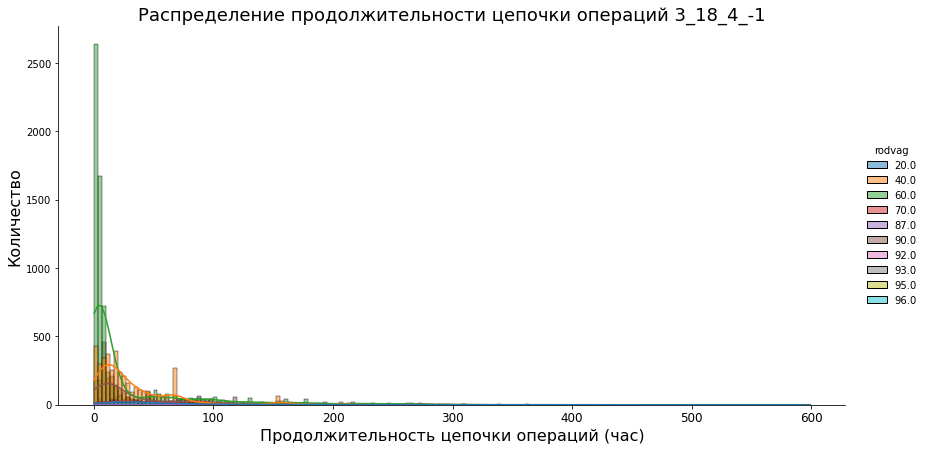

In [30]:
# Графики распределения продолжительностей цепочек
# в зависимости от типа вагона по самым популярным цепочкам
for chain in popular_chains.index[:5]:
    plot_distr(chain,'rodvag')

ВЫВОД: Намечается тенденция к тому, что вагоны с родом 90 в среднем обрабатываются быстрее, чем остальные (коричневая линия заметно смещена влево)

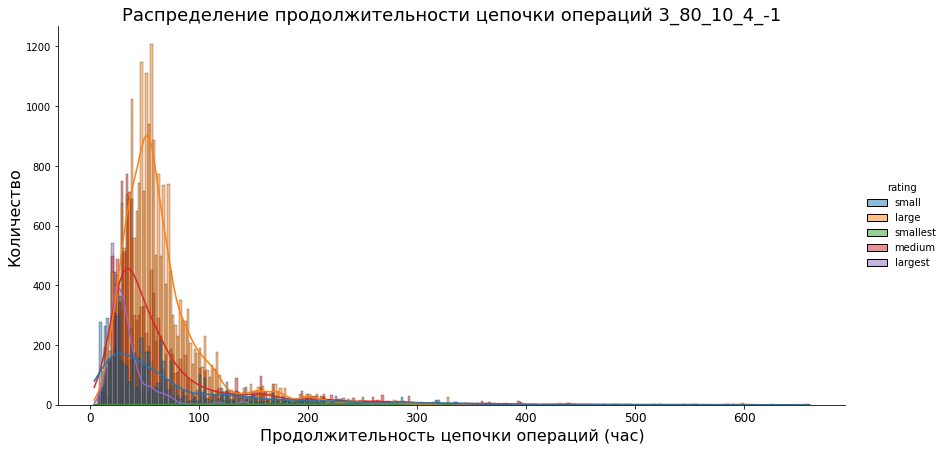

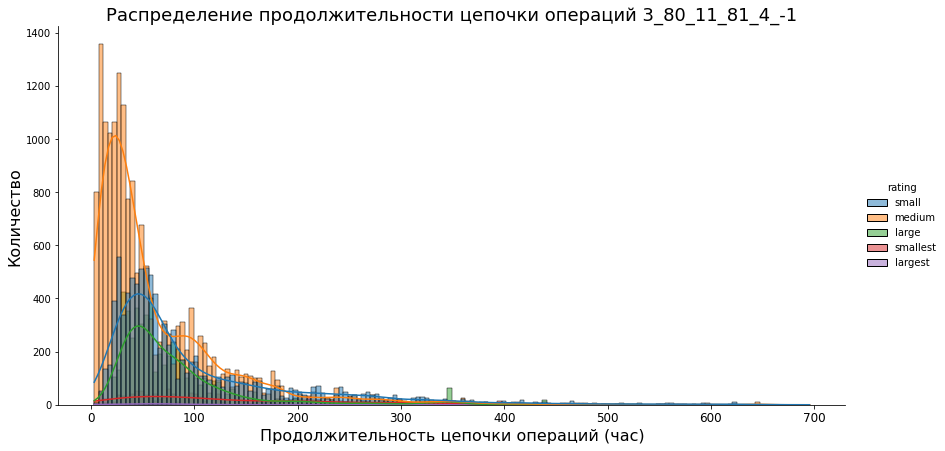

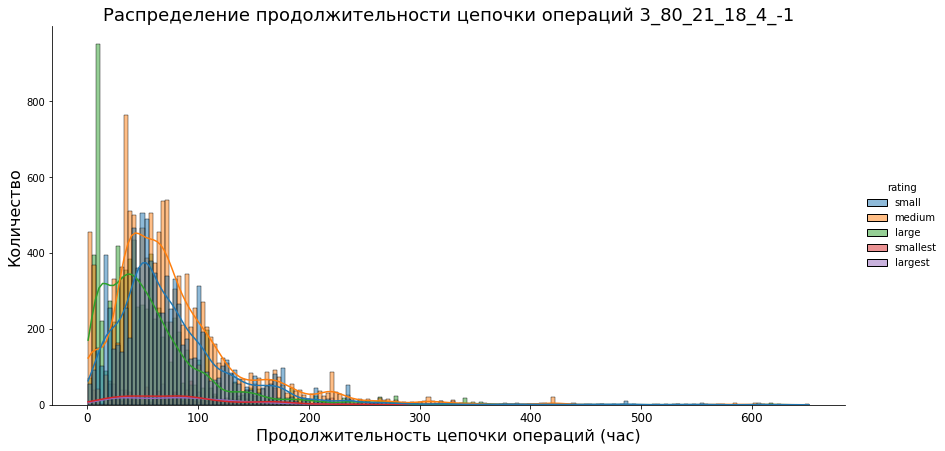

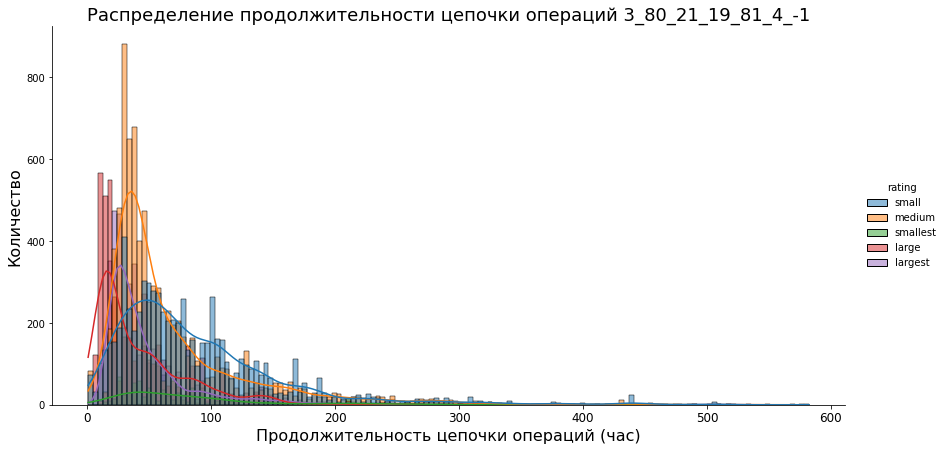

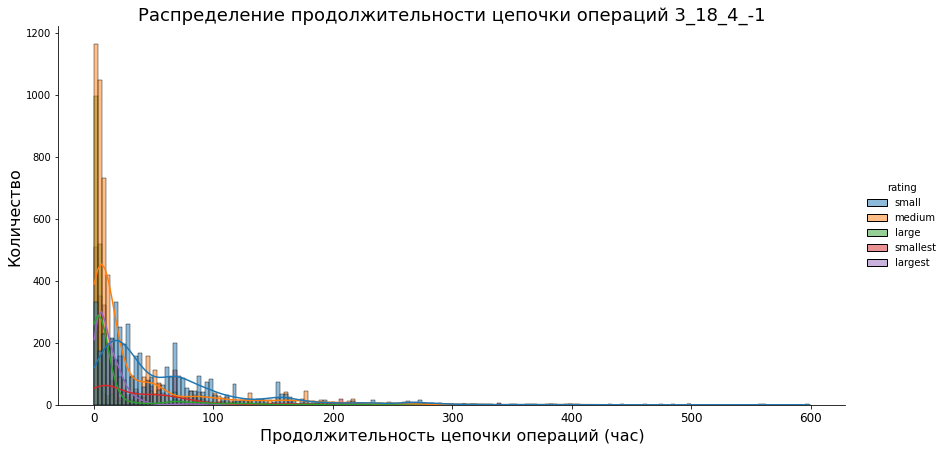

In [31]:
# Графики распределения продолжительностей цепочек
# в зависимости от размера станции по самым популярным цепочкам
for chain in popular_chains.index[:5]:
    plot_distr(chain,'rating')

ВЫВОД: Вероятнее всего время обработки вагона от исключения из поезда до включения в поезд  не зависит от размера станции.

In [34]:
df.loops.value_counts()

0     3597679
1      317376
2       55483
3       14350
4        4294
5        1597
6         618
7         333
9         269
8         234
10        133
11         94
12         77
13         70
14         57
15         34
17         34
16         22
19          9
18          7
20          6
21          6
22          6
23          6
24          6
25          5
26          1
Name: loops, dtype: int64

In [42]:
df.car_st[df.loops==15]

79197      37827334904300
79372      37827573904300
120253     43807932904300
1684637    37827334904601
2378700    44672228910000
74894      30025993933106
74814      30027593933106
74798      30028799933106
73161      30058093933106
75103      30060099933106
73676      30235394933106
73608      30239495933106
72364      30691224933106
72820      30812705933106
71483      30838882933106
84579      30872303933106
84541      30872329933106
83659      30894828933106
2595392    37847001949602
2581437    43699750949602
2595380    37846961950807
2586388    44327013950807
2595308    37846813951104
2581230    44151207951104
2595712    37847019951208
2586576    44477214951208
2595382    37846946951301
2581500    43293141951301
2595314    37846938952709
2594495    37688561953701
79875      37846763955603
123452     42189811955603
321916     37846763960601
317486     42189811960601
Name: car_st, dtype: int64

In [43]:
# Примеры зацикливания операции
df.chains[df.car_st==30060099933106]

4035948                                                    3
4035936                                                 3_80
4035937                                              3_80_28
73105                                             3_80_28_18
73106                                           3_80_28_18_4
73111                                         3_80_28_18_4_4
73079                                       3_80_28_18_4_4_4
73109                                     3_80_28_18_4_4_4_4
73110                                   3_80_28_18_4_4_4_4_4
75097                                 3_80_28_18_4_4_4_4_4_4
75098                               3_80_28_18_4_4_4_4_4_4_4
75095                             3_80_28_18_4_4_4_4_4_4_4_4
75096                           3_80_28_18_4_4_4_4_4_4_4_4_4
75101                         3_80_28_18_4_4_4_4_4_4_4_4_4_4
75102                       3_80_28_18_4_4_4_4_4_4_4_4_4_4_4
75099                     3_80_28_18_4_4_4_4_4_4_4_4_4_4_4_4
75100                   

,start_oper_date,start_oper,end_oper_date,end_oper,duration
0,2020-07-16 16:51:00,3.00,2020-07-16 16:55:00,80.00,0.07
1,2020-07-16 16:55:00,80.00,2020-07-16 17:14:00,28.00,0.32
2,2020-07-16 17:14:00,28.00,2020-07-16 18:03:00,18.00,0.82
3,2020-07-16 18:03:00,18.00,2020-07-16 18:06:00,4.00,0.05
4,2020-07-16 18:06:00,4.00,2020-07-16 18:07:00,4.00,0.02
5,2020-07-16 18:07:00,4.00,2020-07-16 18:08:00,4.00,0.02
6,2020-07-16 18:08:00,4.00,2020-07-16 18:09:00,4.00,0.02
7,2020-07-16 18:09:00,4.00,2020-07-16 18:10:00,4.00,0.02
8,2020-07-16 18:10:00,4.00,2020-07-16 18:11:00,4.00,0.02
9,2020-07-16 18:11:00,4.00,2020-07-16 18:12:00,4.00,0.02


Вагон №: 30060099, станция №: 933106

Расшифровка операций:
3.0 ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           
4.0 ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              
80.0  ПОДАЧА ВАГОНА НА ПП                  
18.0 ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ        
28.0 ВЫГРУЗКА БЕЗ ЗАЧЕТА В ВЫГРУЗКУ        
-1.0 UNKNOWN


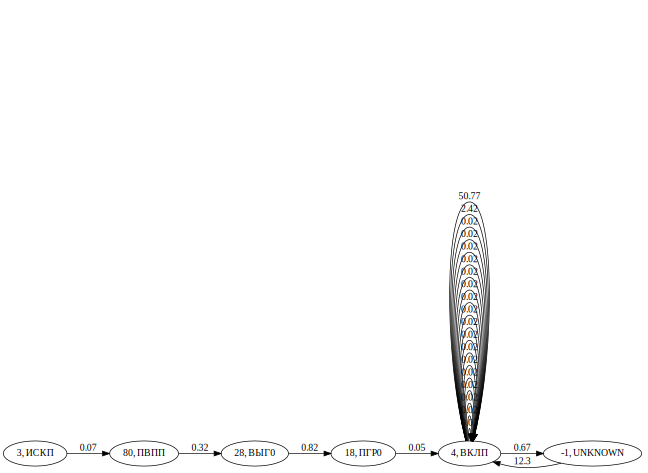

In [47]:
car_st = 30060099933106
get_graf(car_st, to_pdf=False)

Зацикливание происходит на операции 4 примерно каждые 2 минуты. В середине циклов признак загруженности вагона меняется с груженого на порожний и обратно. Есть предположение, что оператор на станции много пытался зарегистрировать отправку поезда, но что-то не получалось. Он менял признак загруженности вагона, но тоже не помогло. В итоге после 17 неудачных попыток, отправка все же удалась.

In [87]:
df[df.car_st==30060099933106]

,index_train,length,car_number,destination_esr,adm,danger,gruz,loaded,operation_car,operation_date,...,weight_brutto,car_st,chains,duration,tot_duration,full_chain,rating,loops,station_count,loops_per_count
4035948,933200729933106.00,-1.00,30060099,933106.00,-1.00,-1.00,-1.00,1.00,3.00,2020-07-16 16:51:00,...,718.00,30060099933106,3,0.00,0.00,False,small,0,4669,0.00
4035936,-1.00,-1.00,30060099,933106.00,-1.00,-1.00,-1.00,1.00,80.00,2020-07-16 16:55:00,...,-1.00,30060099933106,3_80,0.07,0.07,False,small,0,4669,0.00
4035937,-1.00,0.83,30060099,933106.00,20.00,-1.00,236038.00,-1.00,28.00,2020-07-16 17:14:00,...,-1.00,30060099933106,3_80_28,0.32,0.38,False,small,0,4669,0.00
73105,-1.00,0.83,30060099,933200.00,20.00,-1.00,421034.00,-1.00,18.00,2020-07-16 18:03:00,...,-1.00,30060099933106,3_80_28_18,0.82,1.20,False,small,0,4669,0.00
73106,933106609933200.00,0.83,30060099,933200.00,-1.00,-1.00,236038.00,2.00,4.00,2020-07-16 18:06:00,...,1280.00,30060099933106,3_80_28_18_4,0.05,1.25,False,small,0,4669,0.00
73111,933106609933200.00,0.83,30060099,933200.00,-1.00,-1.00,236038.00,2.00,4.00,2020-07-16 18:07:00,...,1280.00,30060099933106,3_80_28_18_4_4,0.02,1.27,False,small,1,4669,0.00
73079,933106609933200.00,0.83,30060099,933200.00,-1.00,-1.00,236038.00,2.00,4.00,2020-07-16 18:08:00,...,1280.00,30060099933106,3_80_28_18_4_4_4,0.02,1.28,False,small,2,4669,0.00
73109,933106609933200.00,0.83,30060099,933200.00,-1.00,-1.00,236038.00,2.00,4.00,2020-07-16 18:09:00,...,1280.00,30060099933106,3_80_28_18_4_4_4_4,0.02,1.30,False,small,3,4669,0.00
73110,933106609933200.00,0.83,30060099,933200.00,-1.00,-1.00,236038.00,1.00,4.00,2020-07-16 18:10:00,...,1280.00,30060099933106,3_80_28_18_4_4_4_4_4,0.02,1.32,False,small,4,4669,0.00
75097,933106609933200.00,0.83,30060099,933200.00,-1.00,-1.00,236038.00,1.00,4.00,2020-07-16 18:11:00,...,1280.00,30060099933106,3_80_28_18_4_4_4_4_4_4,0.02,1.33,False,small,5,4669,0.00


В середине циклов признак загруженности вагона меняется с груженого на порожний и обратно. Есть предположение, что оператор на станции много пытался зарегистрировать отправку поезда, но что-то не получалось. Он менял признак загруженности вагона, но тоже не помогло. В итоге после 17 неудачных попыток, отправка все же удалась.

,start_oper_date,start_oper,end_oper_date,end_oper,duration
0,2020-07-02 11:49:00,3.00,2020-07-03 16:21:00,3.00,28.53
1,2020-07-03 16:21:00,3.00,2020-07-04 11:59:00,3.00,19.63
2,2020-07-04 11:59:00,3.00,2020-07-05 16:41:00,3.00,28.70
3,2020-07-05 16:41:00,3.00,2020-07-06 11:44:00,3.00,19.05
4,2020-07-06 11:44:00,3.00,2020-07-07 16:27:00,3.00,28.72
5,2020-07-07 16:27:00,3.00,2020-07-08 13:47:00,3.00,21.33
6,2020-07-08 13:47:00,3.00,2020-07-09 16:51:00,3.00,27.07
7,2020-07-09 16:51:00,3.00,2020-07-10 11:48:00,3.00,18.95
8,2020-07-10 11:48:00,3.00,2020-07-11 16:45:00,3.00,28.95
9,2020-07-11 16:45:00,3.00,2020-07-12 12:00:00,3.00,19.25


Вагон №: 43807932, станция №: 904300

Расшифровка операций:
3.0 ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           


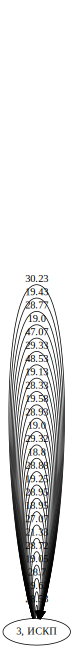

In [51]:
car_st = 43807932904300
get_graf(car_st, to_pdf=False)

In [62]:
# Станции, на которых чаще всего операции зацикливаются
#df.operation_st_esr.unique()
unique, counts = np.unique(df.operation_st_esr, return_counts=True)
st_cnt_dict = dict(zip(unique, counts))
df['station_count'] = df.operation_st_esr.apply(lambda x: st_cnt_dict[x])
df['loops_per_count'] = df.loops / df.station_count
df.tail()

,index_train,length,car_number,destination_esr,adm,danger,gruz,loaded,operation_car,operation_date,...,weight_brutto,car_st,chains,duration,tot_duration,full_chain,rating,loops,station_count,loops_per_count
1180048,-1.00,-1.00,68169127,998100.00,-1.00,-1.00,-1.00,2.00,78.00,2020-07-22 09:00:00,...,-1.00,68169127998100,3_78,0.67,0.67,False,smallest,0,441,0.00
1447159,-1.00,1.00,68169127,993304.00,20.00,-1.00,242016.00,-1.00,10.00,2020-07-25 06:54:00,...,-1.00,68169127998100,3_78_10,69.90,70.57,False,smallest,0,441,0.00
1447172,-1.00,-1.00,68169127,993304.00,-1.00,-1.00,-1.00,1.00,79.00,2020-07-25 07:10:00,...,-1.00,68169127998100,3_78_10_79,0.27,70.83,False,smallest,0,441,0.00
1447157,998100021997502.00,1.00,68169127,993304.00,-1.00,-1.00,242016.00,1.00,4.00,2020-07-25 12:40:00,...,275.00,68169127998100,3_78_10_79_4,5.50,76.33,False,smallest,0,441,0.00
1472430,998100021997502.00,1.00,68169127,993304.00,-1.00,-1.00,242016.00,-1.00,-1.00,2020-07-25 13:44:00,...,275.00,68169127998100,3_78_10_79_4_-1,1.07,77.40,True,smallest,0,441,0.00


0.80    1
0.67    1
0.60    1
0.50    2
0.40    1
0.33    1
0.25    1
0.22    1
0.21    1
0.20    3
0.20    1
0.18    1
0.18    2
0.17    1
0.17    3
0.16    2
0.16    1
0.14    3
0.14    2
0.13    3
0.12    2
0.12    3
0.11    3
0.11    6
0.10    2
Name: loops_per_count, dtype: int64

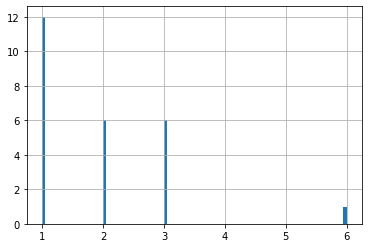

In [68]:
df[df.loops_per_count>0.1].loops_per_count.value_counts().hist(bins=100)
df[df.loops_per_count>0.1].loops_per_count.value_counts().sort_index(ascending=False)

In [79]:
cols = ['car_st','chains','duration','rating','loops_per_count']
df[cols][(df.loops_per_count>0.05)&(df.full_chain==True)].sort_values(by='loops_per_count', ascending=False)

,car_st,chains,duration,rating,loops_per_count
2385640,37545746983603,3_3_3_3_3,167.82,smallest,0.80
1030177,37688967943305,3_3_3,143.93,smallest,0.67
1943214,44603553917320,3_3,94.45,smallest,0.50
3081874,61722500980906,19_19,0.58,smallest,0.50
2364023,52969581985100,19_19,652.17,smallest,0.25
2595645,37827334904601,3_3_3_3_3_3_3_3_3_3_3_3_3_3_3_3_3_3,41.58,smallest,0.22
2085556,44122323834606,3_18_4_4_-1,0.08,smallest,0.20
2585872,43785781945404,3_3_3_3_3_3_3_3_3_3,23.97,smallest,0.18
2595306,37846870945404,3_3_3_3_3_3_3_3_3_3,23.97,smallest,0.18
1210633,30884241957045,3_3,99.48,smallest,0.17


Большинство зацикливаний (более 0.1% от общего количества операций на станции) происходит на очень маленьких станциях, чаще всего с операцией 3

In [86]:
# Количество завершенных цепочек, в которых процент зацикливаний более 0.1% с разбивкой по рейтингу станции
df['rating'][(df.loops_per_count>0.001)&(df.full_chain==True)].value_counts()

smallest    3071
small        765
Name: rating, dtype: int64